In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
# import seaborn as sns

# Function to process CSV files
def process_csv(file_path):
    try:
        df = pd.read_csv(file_path)
        # Perform some processing on the DataFrame
        df.fillna(0, inplace=True)  # Example: Fill NaN values with 0
        return df
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Example usage
file_path = 'SMI_Historical_Data(15Oct).csv'
processed_df = process_csv(file_path)
if processed_df is not None:
    print(processed_df.head())

processed_df['Date'] = pd.to_datetime(processed_df['Date'])
processed_df['Close'] = pd.to_numeric(processed_df['Close'])
processed_df['Open'] = pd.to_numeric(processed_df['Open'])
processed_df['High'] = pd.to_numeric(processed_df['High'])
processed_df['Low'] = pd.to_numeric(processed_df['Low'])

         Date     Close      Open      High       Low    Vol.  Change
0  2022-08-16  11130.44  11182.59  11185.92  11085.13  22.81M  -0.37%
1  2022-08-17  11128.19  11137.84  11192.68  11114.60  58.81M  -0.02%
2  2022-08-18  11167.59  11107.70  11186.50  11090.08  20.22M   0.35%
3  2022-08-19  11156.72  11125.80  11241.18  11125.80  33.74M  -0.10%
4  2022-08-22  11085.84  11105.65  11144.60  11052.39  31.92M  -0.64%


In [54]:
new = processed_df[['Date', 'Close']]
closing_prices = new['Close']

log_returns = np.log(closing_prices / closing_prices.shift(1))
new['log_returns'] = log_returns
new['log_prices'] = np.log(closing_prices)

C:\Users\Lenovo T480\AppData\Local\Temp\ipykernel_19280\3285186701.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['log_returns'] = log_returns
C:\Users\Lenovo T480\AppData\Local\Temp\ipykernel_19280\3285186701.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['log_prices'] = np.log(closing_prices)


In [55]:
new

,Date,Close,log_returns,log_prices
0,2022-08-16,11130.44,NaN,9.317439
1,2022-08-17,11128.19,-0.000202,9.317237
2,2022-08-18,11167.59,0.003534,9.320771
3,2022-08-19,11156.72,-0.000974,9.319797
4,2022-08-22,11085.84,-0.006373,9.313424
...,...,...,...,...
543,2024-10-09,12122.93,0.009277,9.402854
544,2024-10-10,12077.76,-0.003733,9.399121
545,2024-10-11,12154.19,0.006308,9.405429
546,2024-10-14,12259.23,0.008605,9.414034


In [56]:
# new
# print(new['Close'].mean())

In [ ]:
#Geometric Brownian Motion
# S(t) = S(0) * exp((r - 0.5 * sigma^2) * t + sigma * W(t))
# Where:
# S(t) = Stock price at time t
# S(0) = Initial stock price
# r = Drift rate of the stock
# sigma = Volatility of the stock
# t = Time
# W(t) = Wiener process


import random
seed = np.random.seed(69)
barrier_price = 6566.9596
T = 252
dt= 1/T

mean = new['log_returns'].mean()/dt
sigma = new['log_returns'].std()/ np.sqrt(dt)
S_0 = 11130.44
r = 0.01 # 1% - Based on historical data
Nsim = 10000 # Number of simulations
N = 211 # 211 trading days between 15th October 2024 and 8 Aug 2025

discount_factor_formula = np.exp(-r * dt)


In [59]:
'''
Payoff function for the product

Parameters:
initial_price (float): Initial stock price
price (float): Final stock price
barrier_hit (bool): Whether the barrier was hit

Returns:
float: Payoff amount
'''

def payoff(initial_price, price, barrier_hit):
    if barrier_hit:
        return 1000 * (price / initial_price)
    else:
        return 1000 * max(1, 1 + 1.25 * (price / initial_price - 1))

'''
Function to calculate the final price of the product

Parameters:
mean (float): Mean of the log returns
sigma (float): Standard deviation of the log returns
N (int): Time steps
S_0 (float): Initial stock price
r (float): Risk-free rate
Nsim (int): Number of simulations/path generated
barrier_price (float): Barrier price

Returns:
float: Final price of the derivate
'''

def get_final_price(sigma, N,  S_0 = 11130.44, r = 0.01 , Nsim = 10000, barrier_price = 6566.9596):
    # Create a 2D array to store the stock prices for each simulation
    S = np.zeros([Nsim,N])
    S[:,0] = S_0
    # t = range(N)

    # Create an array to store whether the barrier was hit for each simulation
    barrier_hit_each_sim = [True] * Nsim

    for i in range(Nsim):
        S[i,0]=S_0
        for j in range(N-1):
            Z = np.random.normal(0, 1)
            barrier_hit_flag = False
            
            # Calculate the stock price at time t+1 using the Geometric Brownian Motion model with risk-free interet rate
            S[i,j+1] = S[i,j] * np.exp( (r - 0.5 * sigma ** 2) * dt + sigma * Z * np.sqrt(dt) )
            if S[i,j+1] < barrier_price:
                barrier_hit_flag = True
        barrier_hit_each_sim[i] = barrier_hit_flag
    final_prices = np.zeros(Nsim)
    for i in range(Nsim):
        final_prices[i] = payoff(S_0, S[i, -1], barrier_hit_each_sim[i])
    
    # Calculate the expected final price of the derivative discounted to present value
    return np.mean(final_prices) * math.e ** (-r * N/T)

get_final_price(sigma, N, S_0, r, Nsim, barrier_price)

np.float64(1051.081805231827)

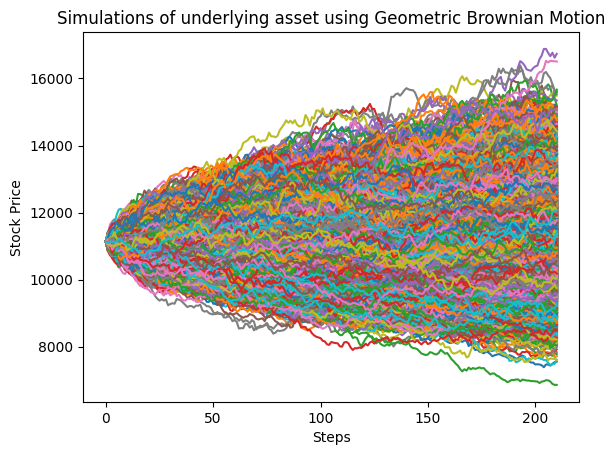

In [60]:
S = np.zeros([Nsim,N])
t = range(N)
barrier_hit_each_sim = [True] * Nsim

for i in range(Nsim):
    S[i,0]=S_0
    for j in range(N-1):
        Z = np.random.normal(0, 1)
        barrier_hit_flag = False
        
        S[i,j+1] = S[i,j] * np.exp( (r - 0.5 * sigma ** 2) * dt + sigma * Z * np.sqrt(dt) )
        if S[i,j+1] < barrier_price:
            barrier_hit_flag = True
    barrier_hit_each_sim[i] = barrier_hit_flag
    plt.plot(t, S[i])

# Add horizontal line for barrier price
# plt.axhline(y=barrier_price, color='r', linestyle='-')
plt.title('Simulations of underlying asset using Geometric Brownian Motion')
plt.xlabel('Steps')
plt.ylabel('Stock Price')
plt.show()


The barrier price is at $6,566.9596. Clearly, the simulation is nowhere near that point.

In [61]:


# def payoff_path(price, S_0, N):
#     final_price = np.zeros(len(price_path))
#     barrier_hit = False
#     for i in range(len(price_path)):
#         price = price_path[i]
#         if price < barrier_price:
#             barrier_hit = True
#             output_price = payoff(S_0, price, barrier_hit)
#             final_price[i] = output_price * np.exp(-r * (N - i))
#     return final_price

final_price = np.zeros(Nsim)
for i in range(Nsim):
    final_price[i] = payoff(S_0, S[i, -1], barrier_hit_each_sim[i])
    


In [62]:
final_price

array([1315.80451769, 1014.0404787 , 1292.4179383 , ..., 1157.62541248,
       1000.        , 1104.96192217])

In [63]:
# Get mean of final price
import math
product_price = np.mean(final_price) * math.e ** (-r * N/T)
print(product_price)

1050.2105992831737
